<a href="https://colab.research.google.com/github/teenwolf395/L5/blob/main/L4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from google.colab import files
import os
import shutil

# Шаг 1: Загружаем kaggle.json
print("Пожалуйста, загрузите файл kaggle.json:")
uploaded = files.upload()

# Проверяем, что файл загружен
if 'kaggle.json' not in uploaded:
    print("Ошибка: файл kaggle.json не найден среди загруженных файлов")
else:
    print("Файл kaggle.json успешно загружен")

    # Шаг 2: Настраиваем Kaggle API
    source_path = 'kaggle.json'
    destination_dir = os.path.expanduser('~/.kaggle')
    destination_path = os.path.join(destination_dir, 'kaggle.json')

    # Создаем директорию, если не существует
    os.makedirs(destination_dir, exist_ok=True)

    # Перемещаем файл
    shutil.move(source_path, destination_path)

    # Устанавливаем правильные права доступа
    os.chmod(destination_path, 0o600)

    print("Kaggle API настроен успешно")

    # Шаг 3: Скачиваем датасет
    print("Скачиваем датасет")
    !kaggle datasets download -d atharvasoundankar/global-cybersecurity-threats-2015-2024

    # Шаг 4: Распаковываем
    import zipfile
    with zipfile.ZipFile('global-cybersecurity-threats-2015-2024.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

    print("Датасет готов к использованию!")

Пожалуйста, загрузите файл kaggle.json:


Saving kaggle.json to kaggle.json
Файл kaggle.json успешно загружен
Kaggle API настроен успешно
Скачиваем датасет
Dataset URL: https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024
License(s): CC0-1.0
global-cybersecurity-threats-2015-2024.zip: Skipping, found more recently modified local copy (use --force to force download)
Датасет готов к использованию!


In [ ]:
threats = pd.DataFrame()
try:
    if os.path.getsize('Global_Cybersecurity_Threats_2015-2024.csv') > 0:
      threats = pd.read_csv('Global_Cybersecurity_Threats_2015-2024.csv')
      type(threats)
      print('Файл проимпортирован\n')
    else:
      print('Файл пустой')
except OSError as e:
    print('Файла не существует')

Файл проимпортирован



In [ ]:
print(threats.isnull().sum())

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64


In [ ]:
threats.describe(include = "all")

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
count,3000,3000.000000,3000,3000,3000.000000,3000.000000,3000,3000,3000,3000.000000
unique,10,NaN,6,7,NaN,NaN,4,4,5,NaN
top,UK,NaN,DDoS,IT,NaN,NaN,Nation-state,Zero-day,Antivirus,NaN
freq,321,NaN,531,478,NaN,NaN,794,785,628,NaN
mean,NaN,2019.570333,NaN,NaN,50.492970,504684.136333,NaN,NaN,NaN,36.476000
std,NaN,2.857932,NaN,NaN,28.791415,289944.084972,NaN,NaN,NaN,20.570768
min,NaN,2015.000000,NaN,NaN,0.500000,424.000000,NaN,NaN,NaN,1.000000
25%,NaN,2017.000000,NaN,NaN,25.757500,255805.250000,NaN,NaN,NaN,19.000000
50%,NaN,2020.000000,NaN,NaN,50.795000,504513.000000,NaN,NaN,NaN,37.000000
75%,NaN,2022.000000,NaN,NaN,75.630000,758088.500000,NaN,NaN,NaN,55.000000


АНАЛИЗ ДАННЫХ КИБЕРАТАК
Размер датасета: (3000, 10)

Первые 5 строк:
   Country  Year        Attack Type     Target Industry  \
0    China  2019           Phishing           Education   
1    China  2019         Ransomware              Retail   
2    India  2017  Man-in-the-Middle                  IT   
3       UK  2024         Ransomware  Telecommunications   
4  Germany  2018  Man-in-the-Middle                  IT   

   Financial Loss (in Million $)  Number of Affected Users Attack Source  \
0                          80.53                    773169  Hacker Group   
1                          62.19                    295961  Hacker Group   
2                          38.65                    605895  Hacker Group   
3                          41.44                    659320  Nation-state   
4                          74.41                    810682       Insider   

  Security Vulnerability Type Defense Mechanism Used  \
0          Unpatched Software                    VPN   
1      

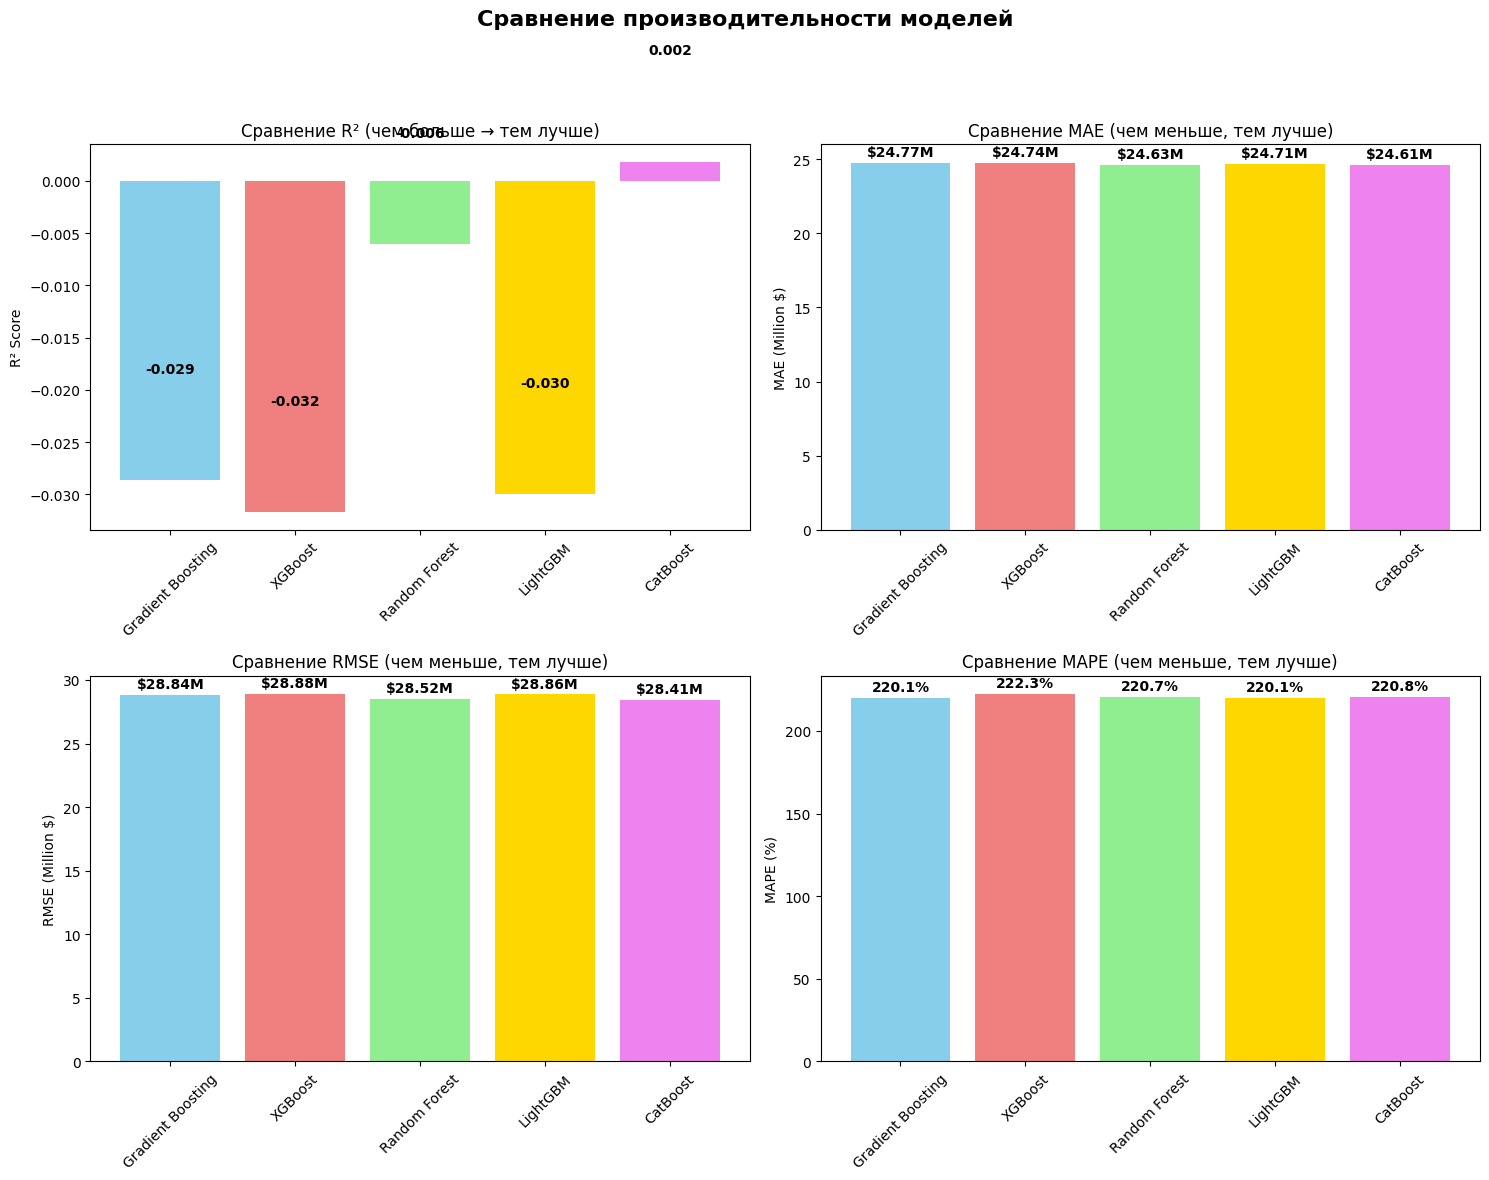

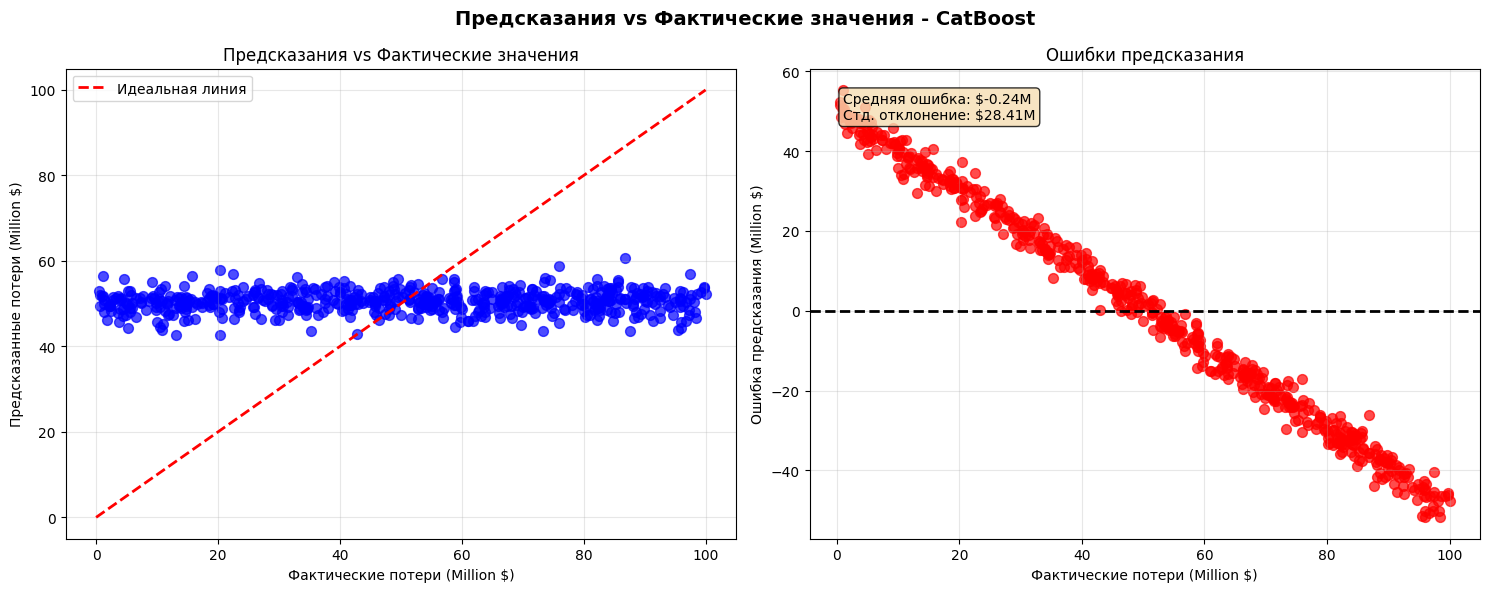

Анализ важности признаков

15 самых важных признаков для CatBoost:
                                       feature  importance
                      Number of Affected Users   14.297865
           Incident Resolution Time (in Hours)   12.148045
                                          Year   10.654766
                         Attack Source_Insider    6.997852
    Security Vulnerability Type_Weak Passwords    5.769371
                                 Country_India    4.494043
                     Target Industry_Education    4.481082
                              Attack Type_DDoS    3.407349
Security Vulnerability Type_Unpatched Software    3.043936
                    Target Industry_Government    3.037603
                         Attack Source_Unknown    2.822076
                     Attack Type_SQL Injection    2.775898
                               Country_Germany    2.448077
Security Vulnerability Type_Social Engineering    2.419749
                           Attack Type_Malware  

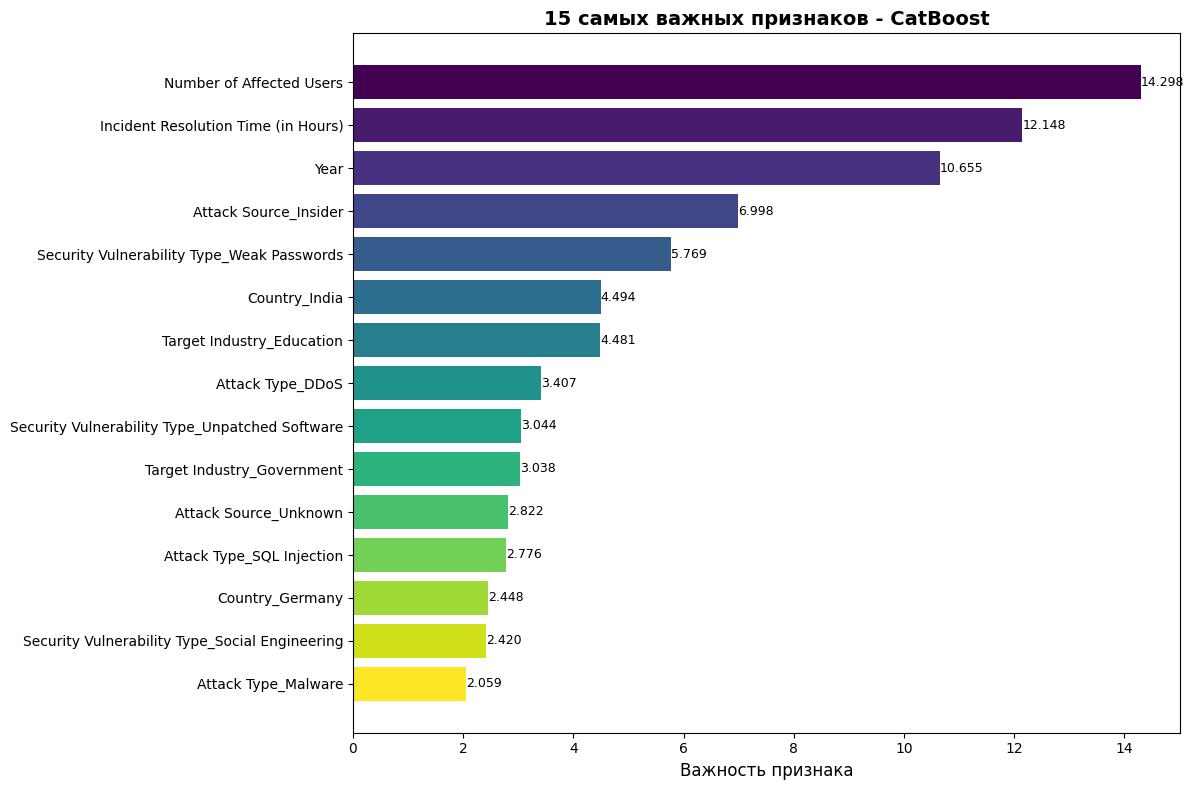


Лучшая модель: CatBoost
Качество предсказания (R²): 0.0018
Средняя абсолютная ошибка: $24.61M
Средняя абсолютная процентная ошибка: 220.77%
Использованное преобразование: Raw

Рейтинг моделей по R²:
1. CatBoost: 0.0018
2. Random Forest: -0.0061
3. Gradient Boosting: -0.0286
4. LightGBM: -0.0300
5. XGBoost: -0.0317


In [ ]:
# Инициализация случайного seed для воспроизводимости
np.random.seed(42)

# ============================================================================
# ЗАГРУЗКА И АНАЛИЗ ДАННЫХ
# ============================================================================

print("=" * 60)
print("АНАЛИЗ ДАННЫХ КИБЕРАТАК")
print("=" * 60)

data = threats.copy()

print(f"Размер датасета: {data.shape}")
print("\nПервые 5 строк:")
print(data.head())

print("\nТипы данных:")
print(data.dtypes)

# Диагностика данных перед обучением

# Проверяем целевую переменную
print("Анализ целевой переменной:")
print(f"Financial Loss статистика:")
print(f"Min: ${data['Financial Loss (in Million $)'].min():.2f}M")
print(f"Max: ${data['Financial Loss (in Million $)'].max():.2f}M")
print(f"Mean: ${data['Financial Loss (in Million $)'].mean():.2f}M")
print(f"Std: ${data['Financial Loss (in Million $)'].std():.2f}M")
print(f"Unique values: {data['Financial Loss (in Million $)'].nunique()}")
print(f"Zero values: {(data['Financial Loss (in Million $)'] == 0).sum()}")

# Проверяем пропуски
print(f"\nПропуски в данных:")
print(f"Всего пропусков: {data.isnull().sum().sum()}")
for col in data.columns:
    missing = data[col].isnull().sum()
    if missing > 0:
        print(f"{col}: {missing} пропусков ({missing/len(data)*100:.1f}%)")

# Проверяем константные колонки
constant_cols = []
for col in data.columns:
    if data[col].nunique() <= 1:
        constant_cols.append(col)
if constant_cols:
    print(f"\nКонстантные колонки: {constant_cols}")
else:
    print(f"\nКонстантных колонок нет")

# Подготовка данных

# Убедимся, что целевая переменная числовая
data['Financial Loss (in Million $)'] = pd.to_numeric(data['Financial Loss (in Million $)'], errors='coerce')

# Определение признаков и целевой переменной
X = data.drop('Financial Loss (in Million $)', axis=1)
y = data['Financial Loss (in Million $)']

# Удаляем строки с пропусками в целевой переменной
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"После очистки: {X.shape}")

# Тестируем разные преобразования
print("\nТестирование преобразований целевой переменной:")

# Вариант 1: Без преобразований
y_raw = y.copy()
use_log_transform_raw = False
use_sqrt_transform_raw = False

# Вариант 2: Логарифмическое преобразование
try:
    y_log = np.log1p(y)
    use_log_transform_log = True
    use_sqrt_transform_log = False
    print("Логарифмическое преобразование применено")
except Exception as e:
    y_log = y.copy()
    use_log_transform_log = False
    use_sqrt_transform_log = False
    print(f"Логарифмирование не применено: {e}")

# Вариант 3: Квадратный корень (менее агрессивное преобразование)
try:
    y_sqrt = np.sqrt(y)
    use_log_transform_sqrt = False
    use_sqrt_transform_sqrt = True
    print("Преобразование квадратным корнем применено")
except Exception as e:
    y_sqrt = y.copy()
    use_log_transform_sqrt = False
    use_sqrt_transform_sqrt = False
    print(f"Преобразование квадратным корнем не применено: {e}")

# Разделение на train/test для всех вариантов
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y_raw, test_size=0.2, random_state=42)
_, _, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
_, _, y_train_sqrt, y_test_sqrt = train_test_split(X, y_sqrt, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Определение типов признаков
categorical_features = ['Country', 'Attack Type', 'Target Industry',
                       'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']
numeric_features = ['Year', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']

# Убедимся, что числовые признаки действительно числовые
for col in numeric_features:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

print(f"\nКатегориальные признаки: {categorical_features}")
print(f"Числовые признаки: {numeric_features}")

# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
    verbose_feature_names_out=False
)

# Определение метрик

def calculate_mape(y_true, y_pred):
    """Расчет Mean Absolute Percentage Error"""
    # Защита от деления на ноль
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(y_true, y_pred, model_name, use_log=False, use_sqrt=False):
    """Оценка модели по всем метрикам"""
    if use_log:
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
    elif use_sqrt:
        y_true_orig = y_true ** 2
        y_pred_orig = y_pred ** 2
    else:
        y_true_orig = y_true
        y_pred_orig = y_pred

    metrics = {
        'MAE': mean_absolute_error(y_true_orig, y_pred_orig),
        'RMSE': np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        'R2': r2_score(y_true_orig, y_pred_orig),
        'MAPE': calculate_mape(y_true_orig, y_pred_orig)
    }

    return metrics

# Диагностика с простыми моделями

# Сначала подготавливаем данные
preprocessor.fit(X_train, y_train_raw)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"Данные подготовлены")
print(f"Количество признаков: {len(feature_names)}")

# Тестируем простые модели на разных преобразованиях
simple_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree (depth=3)': DecisionTreeRegressor(max_depth=3, random_state=42),
    'Random Forest (simple)': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
}

transformations = [
    ('Raw', y_train_raw, y_test_raw, False, False),
    ('Log', y_train_log, y_test_log, True, False),
    ('Sqrt', y_train_sqrt, y_test_sqrt, False, True)
]

print("\nТестирование простых моделей на разных преобразованиях:")

best_simple_r2 = -float('inf')
best_simple_config = None

for transform_name, y_tr, y_te, use_log, use_sqrt in transformations:
    print(f"\nПреобразование: {transform_name}")

    for name, model in simple_models.items():
        try:
            model.fit(X_train_df, y_tr)
            y_pred = model.predict(X_test_df)
            metrics = evaluate_model(y_te, y_pred, name, use_log, use_sqrt)

            print(f"{name}: R² = {metrics['R2']:.4f}, MAE = ${metrics['MAE']:.2f}M")

            if metrics['R2'] > best_simple_r2:
                best_simple_r2 = metrics['R2']
                best_simple_config = (transform_name, name, metrics['R2'], use_log, use_sqrt)

        except Exception as e:
            print(f"{name}: Ошибка - {e}")

# Базовая модель (предсказывает среднее)
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_df, y_train_raw)
y_pred_dummy = dummy.predict(X_test_df)
dummy_r2 = r2_score(y_test_raw, y_pred_dummy)

print(f"\nБазовая модель (среднее): R² = {dummy_r2:.4f}")

if best_simple_config:
    print(f"\nЛучшая простая модель:")
    print(f"Преобразование: {best_simple_config[0]}")
    print(f"Модель: {best_simple_config[1]}")
    print(f"R² = {best_simple_config[2]:.4f}")

use_log_transform_best = False
use_sqrt_transform_best = False
best_transform_name = "Raw"

# Выбираем лучшее преобразование на основе диагностики
if best_simple_config and best_simple_config[2] > 0.1:  # если есть хоть какая-то предсказательная сила
    best_transform_name, _, _, use_log_best, use_sqrt_best = best_simple_config
    if use_log_best:
        y_train_best = y_train_log
        y_test_best = y_test_log
        use_log_transform_best = True
        use_sqrt_transform_best = False
    elif use_sqrt_best:
        y_train_best = y_train_sqrt
        y_test_best = y_test_sqrt
        use_log_transform_best = False
        use_sqrt_transform_best = True
    else:
        y_train_best = y_train_raw
        y_test_best = y_test_raw
        use_log_transform_best = False
        use_sqrt_transform_best = False
else:
    # Если все модели плохие, используем исходные данные
    print("Все модели показывают плохие результаты, используем исходные данные")
    y_train_best = y_train_raw
    y_test_best = y_test_raw
    use_log_transform_best = False
    use_sqrt_transform_best = False
    best_transform_name = "Raw"

print(f"\nВыбрано преобразование: {best_transform_name}")
print(f"use_log_transform_best: {use_log_transform_best}")
print(f"use_sqrt_transform_best: {use_sqrt_transform_best}")

# Обучение основных моделей на лучшем преобразовании

print("Обучение основных моделей:")

# Переподготавливаем данные с выбранным преобразованием
X_train_df_best = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df_best = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

# Определение моделей с упрощенными параметрами
models = {
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=50, random_state=42, max_depth=4, learning_rate=0.1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=50, random_state=42, max_depth=4, learning_rate=0.1
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=50, random_state=42, max_depth=5
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=50, random_state=42, max_depth=4, verbose=-1, learning_rate=0.1
    ),
    'CatBoost': CatBoostRegressor(
        n_estimators=50, random_state=42, max_depth=4, verbose=False, learning_rate=0.1
    )
}

print(f"Все 5 моделей инициализированы с упрощенными параметрами")

results = {}

for name, model in models.items():
    print(f"\n--- Обучение {name} ---")

    try:
        # Обучаем на DataFrame с feature names
        model.fit(X_train_df_best, y_train_best)

        # Предсказание
        y_pred = model.predict(X_test_df_best)

        # Оценка - используем правильные переменные
        metrics = evaluate_model(y_test_best, y_pred, name, use_log_transform_best, use_sqrt_transform_best)

        # Сохранение результатов
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'metrics': metrics,
            'feature_names': feature_names
        }

        print(f"{name} успешно обучена")
        print(f"R² = {metrics['R2']:.4f}, MAE = ${metrics['MAE']:.2f}M")

    except Exception as e:
        print(f"Ошибка при обучении {name}: {e}")
        continue

# Проверяем, что хотя бы одна модель обучилась успешно
if not results:
    print("Ни одна модель не была успешно обучена! Проверьте данные.")
    exit()

print(f"\nУспешно обучено моделей: {len(results)} из {len(models)}")


# Сравнение моделей и диагностика R²

print("Сравнительный анализ моделей")

# Создание DataFrame с результатами
results_df = pd.DataFrame({
    model: results[model]['metrics'] for model in results.keys()
}).T

print("\nСравнительная таблица метрик:")
print(results_df.round(4))

# Определение лучшей модели по R²
best_model_name = results_df['R2'].idxmax()
best_model_metrics = results_df.loc[best_model_name]

print(f"Лучшая модель: {best_model_name}")
print(f"R²: {best_model_metrics['R2']:.4f}")
print(f"MAE: ${best_model_metrics['MAE']:.2f}M")
print(f"RMSE: ${best_model_metrics['RMSE']:.2f}M")
print(f"MAPE: {best_model_metrics['MAPE']:.2f}%")

# Анализ качества моделей
negative_r2_models = results_df[results_df['R2'] < 0]
if len(negative_r2_models) > 0:
    print(f"\nМодели с отрицательным R²:")
    for model_name in negative_r2_models.index:
        r2_val = results_df.loc[model_name, 'R2']
        print(f"{model_name}: R² = {r2_val:.4f}")

if best_model_metrics['R2'] <= 0:
    print(f"\nКритическая проблема: Лучшая модель имеет R² <= 0")

# Визуализация результатов

def plot_model_comparison(results_df):
    """Визуализация сравнения моделей"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Сравнение производительности моделей', fontsize=16, fontweight='bold')

    models_list = results_df.index
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet'][:len(models_list)]

    # Сравнение R²
    r2_scores = results_df['R2']
    bars1 = axes[0, 0].bar(models_list, r2_scores, color=colors)
    axes[0, 0].set_title('Сравнение R² (чем больше → тем лучше)')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    for bar, value in zip(bars1, r2_scores):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Сравнение MAE
    mae_scores = results_df['MAE']
    bars2 = axes[0, 1].bar(models_list, mae_scores, color=colors)
    axes[0, 1].set_title('Сравнение MAE (чем меньше, тем лучше)')
    axes[0, 1].set_ylabel('MAE (Million $)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    for bar, value in zip(bars2, mae_scores):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mae_scores)*0.01,
                       f'${value:.2f}M', ha='center', va='bottom', fontweight='bold')

    # Сравнение RMSE
    rmse_scores = results_df['RMSE']
    bars3 = axes[1, 0].bar(models_list, rmse_scores, color=colors)
    axes[1, 0].set_title('Сравнение RMSE (чем меньше, тем лучше)')
    axes[1, 0].set_ylabel('RMSE (Million $)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    for bar, value in zip(bars3, rmse_scores):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_scores)*0.01,
                       f'${value:.2f}M', ha='center', va='bottom', fontweight='bold')

    # Сравнение MAPE
    mape_scores = results_df['MAPE']
    bars4 = axes[1, 1].bar(models_list, mape_scores, color=colors)
    axes[1, 1].set_title('Сравнение MAPE (чем меньше, тем лучше)')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    for bar, value in zip(bars4, mape_scores):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mape_scores)*0.01,
                       f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(best_model_name, results, y_test, use_log=False, use_sqrt=False):
    """Визуализация предсказаний лучшей модели"""

    best_predictions = results[best_model_name]['predictions']

    if use_log:
        y_test_orig = np.expm1(y_test)
        best_predictions_orig = np.expm1(best_predictions)
    elif use_sqrt:
        y_test_orig = y_test ** 2
        best_predictions_orig = best_predictions ** 2
    else:
        y_test_orig = y_test
        best_predictions_orig = best_predictions

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Предсказания vs Фактические значения - {best_model_name}', fontsize=14, fontweight='bold')

    # Scatter plot предсказаний vs фактических значений
    axes[0].scatter(y_test_orig, best_predictions_orig, alpha=0.7, color='blue', s=50)
    max_val = max(y_test_orig.max(), best_predictions_orig.max())
    axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Идеальная линия')
    axes[0].set_xlabel('Фактические потери (Million $)')
    axes[0].set_ylabel('Предсказанные потери (Million $)')
    axes[0].set_title('Предсказания vs Фактические значения')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Ошибки предсказания
    errors = best_predictions_orig - y_test_orig
    axes[1].scatter(y_test_orig, errors, alpha=0.7, color='red', s=50)
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Фактические потери (Million $)')
    axes[1].set_ylabel('Ошибка предсказания (Million $)')
    axes[1].set_title('Ошибки предсказания')
    axes[1].grid(True, alpha=0.3)

    # Статистика ошибок
    avg_error = np.mean(errors)
    std_error = np.std(errors)
    axes[1].text(0.05, 0.95, f'Средняя ошибка: ${avg_error:.2f}M\nСтд. отклонение: ${std_error:.2f}M',
                transform=axes[1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Визуализация результатов (если есть положительный R²)
if best_model_metrics['R2'] > 0:
    plot_model_comparison(results_df)
    plot_predictions_vs_actual(best_model_name, results, y_test_best, use_log_transform_best, use_sqrt_transform_best)
else:
    print("\nВизуализация пропущена из-за отрицательного R²")

# Анализ важности признаков для лучшей модели

if best_model_metrics['R2'] > 0:  # Только если модель имеет смысл
    print("Анализ важности признаков")

    best_model = results[best_model_name]['model']
    feature_names = results[best_model_name]['feature_names']

    # Анализ важности признаков
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\n15 самых важных признаков для {best_model_name}:")
        print(feature_importance.head(15).to_string(index=False))

        # Визуализация важности признаков
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)

        colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(top_features)))

        bars = plt.barh(top_features['feature'], top_features['importance'], color=colors)

        plt.xlabel('Важность признака', fontsize=12)
        plt.title(f'15 самых важных признаков - {best_model_name}', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()

        # Добавляем значения на барплот
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}', ha='left', va='center', fontsize=9)

        plt.tight_layout()
        plt.show()


print(f"\nЛучшая модель: {best_model_name}")
print(f"Качество предсказания (R²): {best_model_metrics['R2']:.4f}")
print(f"Средняя абсолютная ошибка: ${best_model_metrics['MAE']:.2f}M")
print(f"Средняя абсолютная процентная ошибка: {best_model_metrics['MAPE']:.2f}%")
print(f"Использованное преобразование: {best_transform_name}")

# Рейтинг моделей
print(f"\nРейтинг моделей по R²:")
sorted_models = results_df['R2'].sort_values(ascending=False)
for i, (model, score) in enumerate(sorted_models.items(), 1):
    print(f"{i}. {model}: {score:.4f}")